In [1]:
import pandas as pd 
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
#import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.api as sm
from sklearn.cross_validation import KFold
import pylab as pl
import statsmodels.tools
%matplotlib inline

##STEP 2

After having obtained a prediction for the number of requests for each type of 311 service request, we are going to try calculate the relative error for the predictions and find clusters of similar errors. The goal of cluster the errors is to detect areas where the demographic features are not enough to predict the number of 311 requests and, instead, there are more features (about the neighborhood itself instead of its population) that affect the volume of 311 requests. 

This notebook contain 4 analysis:

1) the error is calculated for each type of complain 

2) We analyze first a specific case for spatial distribution of the error: service requests about 'Noise' and its spatial autocorrelation (using the Moran's I).

3) Then, we repeat the process for each type of requests, we filter for those types of requests that are statistically significant and we take the one with the highest Moran's I (that means, with the highest spatial autocorrelation) for analysis.

OUTPUT: outputs/phase2_spatial_autocorrelation.csv stores the Moran's I for those types of requests with statistically significant Moran's I value for further analysis at the end of the notebook

4) Feature selection and regression is performed for those types of complains with Moran's I values greater than 0.2

OUTPUTS: 

outputs/phase2_coefficients.csv with the coefficients obtained after running the LASSO over the features with high spatial autocorrelation

outputs/phase2_predicted.csv with the predicted number of calls for the complains after running the LASSO over the features with high spatial autocorrelation


In [2]:
#read the prediction obtained in step1.
predicted_table=pd.read_csv('outputs/predicted_values.csv')
observed_table=pd.read_csv('outputs/observed_values.csv')
predicted_table.index=predicted_table['Unnamed: 0']
predicted_table.drop(['Unnamed: 0'],inplace=True,axis=1)
del predicted_table.index.name
observed_table.index=observed_table['Unnamed: 0']
observed_table.drop(['Unnamed: 0'],inplace=True,axis=1)
del observed_table.index.name

In [3]:
predicted_table.head()

,Allerton-Pelham Gardens,Annadale-Huguenot-Prince's Bay-Eltingville,Arden Heights,Astoria,Auburndale,Baisley Park,Bath Beach,Battery Park City-Lower Manhattan,Bay Ridge,Bayside-Bayside Hills,...,Williamsbridge-Olinville,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn-Wakefield,Woodside,Yorkville,park-cemetery-etc-Bronx,park-cemetery-etc-Manhattan,park-cemetery-etc-Queens
Lead,5.475991,6.842618,4.953731,25.094258,4.912213,4.805106,7.120284,19.388024,26.101691,12.538724,...,9.760725,3.017439,7.200958,10.133781,7.956403,10.078224,39.361682,-1.384721,0.195632,-1.612291
WATER LEAK,69.619765,14.782818,9.577409,355.777137,21.707367,94.407597,90.792880,34.975983,279.063246,41.986327,...,276.839023,120.498974,57.187734,168.500145,148.430092,155.608289,185.265851,11.893778,59.386199,3.658290
Bus Stop Shelter Placement,0.597771,0.618073,0.537218,2.679893,0.381693,0.697188,0.701274,1.779416,2.695809,1.041111,...,1.418393,0.526122,0.678636,1.198348,1.056407,1.080223,3.609504,-0.149620,0.077083,-0.183590
Found Property,0.706029,0.143493,0.398000,1.838258,0.396765,0.408955,0.559015,11.842338,1.173234,0.315869,...,0.787743,1.696356,0.891943,0.650802,0.647299,1.135871,3.967470,0.576600,0.978185,0.635692
For Hire Vehicle Complaint,10.021396,8.533202,8.930713,13.658009,9.000638,9.374346,9.685883,38.223544,12.674389,9.424493,...,11.069373,12.364101,10.147008,10.773314,10.144821,11.617608,17.680931,9.086463,10.294076,9.386829


Now, we are going to obtain a table that assigns to each type of request $t$, the error between the predicted and observed values:

$$error(A,t)=  \frac{ \hat{S} (A,t) }{S(A,t)}-1 $$

where $\hat{S}$ is the predicted number of requests in the NTA $A$ for the type of request $t$, and $S$ is the observed number of requests

###PROBLEM!! 
there are many NTAs that has 0 observed requests of type $t$, then the $error(A,t)$ formula diverges.
For now, we are going to change the formula to:

$$error(A,t)=\frac{\hat{S} (A,t) - S(A,t)}{\hat{S}(A,T)}  $$


In [4]:
error_table=(predicted_table-observed_table)/(predicted_table)
error_table.head()

,Allerton-Pelham Gardens,Annadale-Huguenot-Prince's Bay-Eltingville,Arden Heights,Astoria,Auburndale,Baisley Park,Bath Beach,Battery Park City-Lower Manhattan,Bay Ridge,Bayside-Bayside Hills,...,Williamsbridge-Olinville,Williamsburg,Windsor Terrace,Woodhaven,Woodlawn-Wakefield,Woodside,Yorkville,park-cemetery-etc-Bronx,park-cemetery-etc-Manhattan,park-cemetery-etc-Queens
Lead,-0.278307,0.561571,0.596264,0.163155,0.592852,0.791888,0.157337,0.174748,-0.264286,-0.355800,...,0.385292,-0.325628,-3.582724,0.210561,0.120205,0.503881,0.542702,1.000000,1.000000,1.000000
WATER LEAK,0.138176,0.661769,0.582351,0.628981,0.907865,0.343273,0.129888,0.656907,0.172231,0.261664,...,-0.784431,0.834023,0.143173,0.519288,-0.482179,0.588711,0.476428,1.000000,0.309604,1.000000
Bus Stop Shelter Placement,1.000000,1.000000,1.000000,0.253702,1.000000,1.000000,-0.425977,0.438018,-0.112838,1.000000,...,1.000000,1.000000,1.000000,0.165518,1.000000,1.000000,0.168861,1.000000,1.000000,1.000000
Found Property,1.000000,1.000000,1.000000,0.456007,1.000000,1.000000,1.000000,-0.013313,0.147655,1.000000,...,1.000000,1.000000,-0.121148,1.000000,1.000000,0.119618,-2.024598,1.000000,-4.111510,1.000000
For Hire Vehicle Complaint,0.501068,0.882811,1.000000,-0.830428,0.888897,0.466629,-0.135673,-0.412742,-0.577985,0.575574,...,-0.084072,0.352966,0.310141,-0.485151,0.112848,0.139238,0.264745,0.559785,-0.262862,0.147742


In [5]:
#save the errors table
error_table.to_csv('outputs/error_table.csv')

In order to indentify zones which number of requests depends not only on socio-demographic characteristics but also on NTA features, we are going to look at the error spatial distribution.

##let's take a look on how is the distribution of error for just one type of request = 'noise'

In [6]:
noise_error=pd.DataFrame(error_table.loc['Noise'])
noise_error.reset_index(inplace=True)
noise_error.rename(columns={'index': 'ntaname', 'Noise': 'noise error'}, inplace=True)
noise_error.head()

,ntaname,noise error
0,Allerton-Pelham Gardens,0.095738
1,Annadale-Huguenot-Prince's Bay-Eltingville,0.577337
2,Arden Heights,0.246319
3,Astoria,0.076615
4,Auburndale,0.375782


In [7]:
import geopandas as gpd
import mplleaflet
import pysal as ps

In [8]:
#load the NTA geojson and merge with noise error  
nta_json = gpd.read_file('datasets/nta_census_shapefile/NTA_json.geojson')
noise_error_geo=pd.merge(nta_json,noise_error,on=['ntaname'],how='inner')
noise_error_geo.head()

,borocode,boroname,cartodb_id,countyfips,geometry,ntacode,ntaname,percent,pop_2000,pop_2010,pop_diff,shape_area,shape_leng,noise error
0,3,Brooklyn,1,47,(POLYGON ((-73.88828531356056 40.6467224132760...,BK93,Starrett City,-8.7,14621,13354,-1267,11598945.8236,17414.781633,0.713203
1,4,Queens,2,81,(POLYGON ((-73.76809925805176 40.5978459701096...,QN12,Hammels-Arverne-Edgemere,16.6,31645,36885,5240,61904116.8013,83820.120650,0.486097
2,2,Bronx,4,5,(POLYGON ((-73.88438994861654 40.8229673964485...,BX27,Hunts Point,8.2,25142,27204,2062,49734670.5573,44778.618995,0.495952
3,3,Brooklyn,5,47,(POLYGON ((-73.88833929256353 40.6467102284149...,BK50,Canarsie,-1.6,85058,83693,-1365,82015446.6700,43701.791058,0.515884
4,2,Bronx,6,5,(POLYGON ((-73.78833349834532 40.8346671297593...,BX10,Pelham Bay-Country Club-City Island,-2.1,27140,26583,-557,40248130.5227,139408.564885,-0.003548


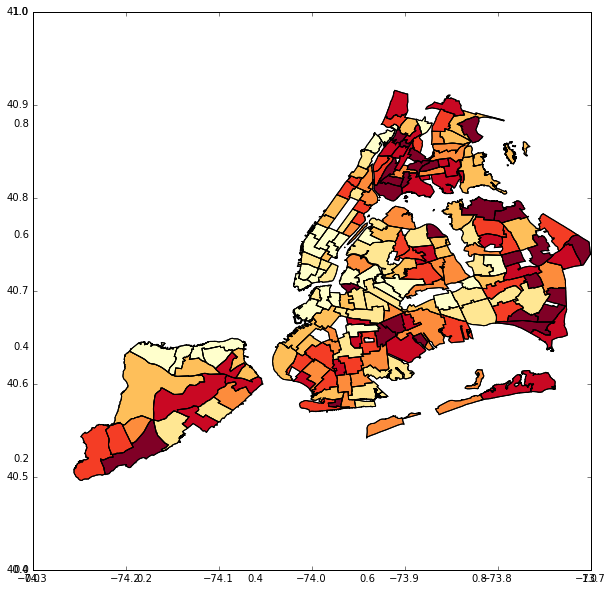

In [9]:
f, ax = plt.subplots(1, figsize=(10,10))
noise_error_geo.plot(column='noise error', scheme='QUANTILES', k=7, alpha=1, colormap='YlOrRd')
#mplleaflet.display(fig=f, crs=noise_error_geo.crs,tiles= ('http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png','attributions'))

Just by watching, it seems like the spatial distribution of the error for noise requests is random (not a lot of clusters iddentified), however, a deeper exploration tell us that there are clusters of high error (darker red - purple) in the Queens area around the airport and in the Bronx. 

Let's see what is the MORAN's I value in this case

In [10]:
psGeom = ps.open('datasets/nta_census_shapefile/neighborhood_nta_census.shp', 'r')
#psGeom=ps.open('datasets/nta_census_shapefile/NTA_json.geojson')

In [11]:
nta_json_ids = gpd.read_file('datasets/nta_census_shapefile/NTA_json.geojson')

In [12]:
#weights matrix
W = ps.buildContiguity(psGeom, criterion='queen', ids=nta_json_ids['ntaname'].values.tolist())
W['West Village']

{u'Chinatown': 1.0,
 u'East Village': 1.0,
 u'Gramercy': 1.0,
 u'Hudson Yards-Chelsea-Flatiron-Union Square': 1.0,
 u'SoHo-TriBeCa-Civic Center-Little Italy': 1.0}

In [13]:
# Now we would like to standardize all the weights. This can be 
# done by specifying 'R' as the matrix transformation. Then, let's
# look again the neighbors of the West Village. All the weights
# should add up to 1.
W.transform = 'R'
W['West Village']

{u'Chinatown': 0.2,
 u'East Village': 0.2,
 u'Gramercy': 0.2,
 u'Hudson Yards-Chelsea-Flatiron-Union Square': 0.2,
 u'SoHo-TriBeCa-Civic Center-Little Italy': 0.2}

In [14]:
# Next, we're going to perform a spatial autocorrelation on the
# 'noise error'  column. We first standardize the values by subtracting
# the mean and divide by the standard deviation.

noise_error_geo2=pd.merge(nta_json_ids,noise_error,on=['ntaname'],how='outer').fillna(value=0)
mask=map(lambda x: x in (W.full()[1]),noise_error_geo2.ntaname)
noise_error_geo3=noise_error_geo2[mask]
Y = noise_error_geo3['noise error'].values
Y = (Y-Y.mean())/Y.std()
len(Y)

190

In [15]:
sl = ps.lag_spatial(W, Y)
noise_error_geo3['w_error'] = sl

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [16]:
# Execute the Moran's I calculation
mi = ps.Moran(Y, W)
mi.I

0.23858240013862544

In [17]:
# Check the p-value of the calculation. This has to be < 0.05 for our
# calculation to be statistically significant.

mi.p_sim

0.001

In [18]:
import seaborn as sns

C:\Users\Marco\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


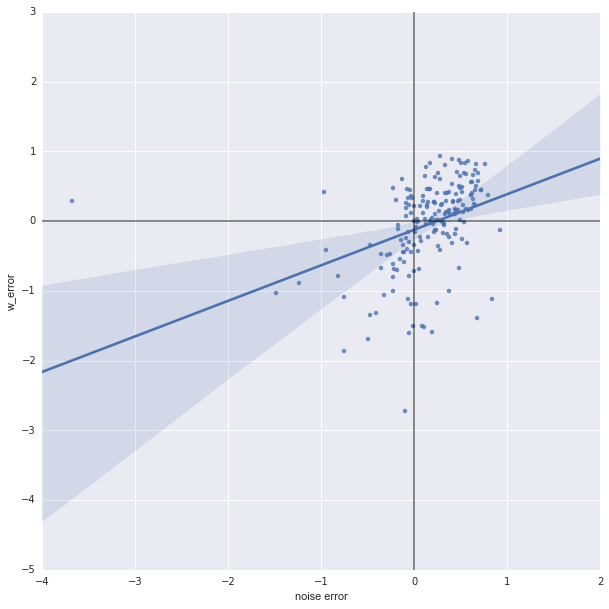

In [19]:
# It's time to look at the Moran Scatter Plot to inspet the results

f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(x='noise error', y='w_error', data=noise_error_geo3)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

In [20]:
# Now, let's look at local indicator. Overall, we see some
# trends, but not so strong. Maybe a local indicator test
# could help us see in details how things are correlated.
# We run the Moran's LISA calculation provided by PySAL.

lisa = ps.Moran_Local(Y, W)

In [21]:
# Let's narrow down to those neighborhoods that are
# statistically significant.

S = lisa.p_sim < 0.05
Q = lisa.q
# Next, we'll turn those into a GeoDataFrame for visualization.
records = map(lambda x: (noise_error_geo3.iloc[x]['ntaname'], Q[x], noise_error_geo3.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])
gdata = gpd.GeoDataFrame(records, columns=('ntaname', 'quadrant', 'geometry'))
gdata.head()

,ntaname,quadrant,geometry
0,Hunts Point,1,(POLYGON ((-73.88438994861654 40.8229673964485...
1,Battery Park City-Lower Manhattan,3,(POLYGON ((-74.00078295275674 40.6942865156645...
2,Douglas Manor-Douglaston-Little Neck,1,(POLYGON ((-73.71351828105992 40.7598377308308...
3,East New York,1,(POLYGON ((-73.86106295016751 40.6743429347301...
4,Fresh Meadows-Utopia,4,(POLYGON ((-73.7775750688206 40.73019327580699...


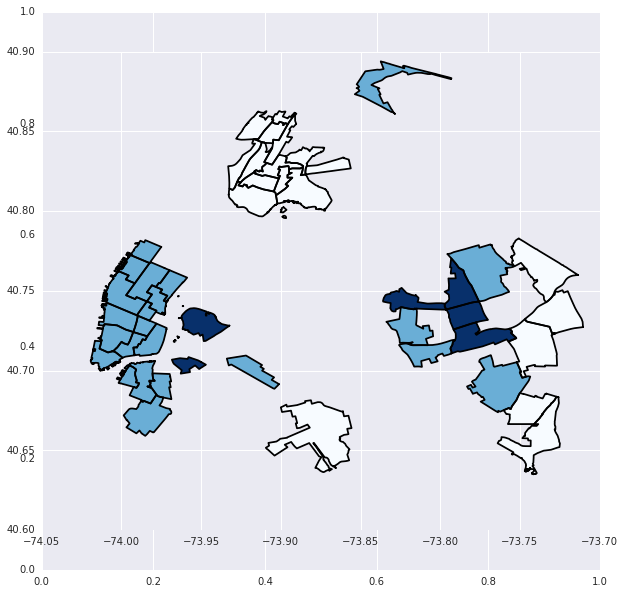

In [22]:
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues')

In [23]:
quadrantsDf=gdata[['ntaname','quadrant']]
#quadrantsDf.to_csv('Data/quadrantsDf.csv')
merged=pd.merge(noise_error_geo3,gdata,on=['ntaname'],how='inner')

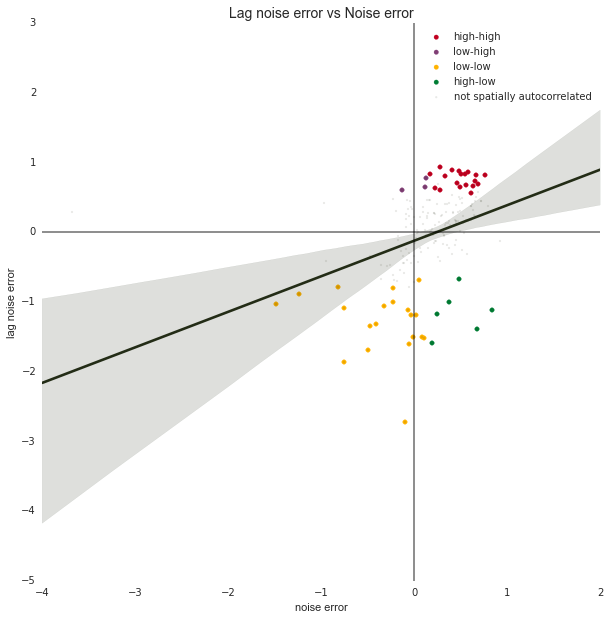

In [24]:
# It's time to look at the Moran Scatter Plot to inspet the results
f, ax = plt.subplots(1, figsize=(10,10))
q1=merged[merged['quadrant']==1]
plt.scatter(x=q1['noise error'], y=q1['w_error'], color='#C10020',marker='o',label='high-high')
q2=merged[merged['quadrant']==2]
plt.scatter(x=q2['noise error'], y=q2['w_error'], color='#803E75',marker='o',label='low-high')
q3=merged[merged['quadrant']==3]
plt.scatter(x=q3['noise error'], y=q3['w_error'], color='#FFB300',marker='o',label='low-low')
q4=merged[merged['quadrant']==4]
plt.scatter(x=q4['noise error'], y=q4['w_error'], color='#007D34',marker='o',label='high-low')
sns.regplot(x='noise error', y='w_error', data=noise_error_geo3, color='#232C16', marker='.',
           scatter_kws={'alpha':0.1}, 
            fit_reg=True, label='not spatially autocorrelated')
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.xlabel('noise error')
plt.ylabel('lag noise error')
ax.set_title("Lag noise error vs Noise error", fontsize=14)
ax.set_axis_bgcolor('w')
#ax.set_axis_bgcolor((1, 0, 0))
pl.plt.legend()

In this case, most of the point fall out the confidence interval. The map also shows that the clusters based on the error value are not too big in this case.

# Process Authomatization

In [25]:
nta_json = gpd.read_file('datasets/nta_census_shapefile/NTA_json.geojson')
psGeom = ps.open('datasets/nta_census_shapefile/neighborhood_nta_census.shp', 'r')
sp_aut_index=pd.DataFrame(index=error_table.index, columns=['morans I','p_sim'])
for typeof in error_table.index:
    type_error=pd.DataFrame(error_table.loc[typeof])
    type_error.reset_index(inplace=True)
    type_error.rename(columns={'index': 'ntaname', typeof: 'error'}, inplace=True)
    type_error_geo=pd.merge(nta_json,type_error,on=['ntaname'],how='inner')
    W = ps.buildContiguity(psGeom, criterion='queen', ids=nta_json['ntaname'].values.tolist())
    W.transform = 'R'
    type_error_geo2=pd.merge(nta_json,type_error,on=['ntaname'],how='outer').fillna(value=0)
    mask=map(lambda x: x in (W.full()[1]),type_error_geo2.ntaname)
    type_error_geo3=type_error_geo2[mask]
    Y = type_error_geo3['error'].values
    Y = (Y-Y.mean())/Y.std()
    sl = ps.lag_spatial(W, Y)
    type_error_geo3['w_error'] = sl
    mi = ps.Moran(Y, W)
    sp_aut_index.loc[typeof,'morans I']=mi.I
    sp_aut_index.loc[typeof,'p_sim']=mi.p_sim  #p value should be <0.05

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
sp_aut_index.head()

,morans I,p_sim
Lead,0.374006,0.001
WATER LEAK,0.2449103,0.002
Bus Stop Shelter Placement,0.132091,0.008
Found Property,0.2420908,0.001
For Hire Vehicle Complaint,0.1518844,0.001


Based on the p value, we are going to filter those types of requests that are statistically significant. 

In [27]:
spatial_analysis=sp_aut_index[sp_aut_index.p_sim<0.05]
print len(sp_aut_index), len(spatial_analysis)

102 78


In [28]:
spatial_analysis.sort('morans I',ascending= False).head()

,morans I,p_sim
HEAT/HOT WATER,0.6217601,0.001
Construction,0.5864066,0.001
Taxi Complaint,0.5334489,0.001
Street Light Condition,0.5195586,0.001
PLUMBING,0.5138718,0.001


In [29]:
spatial_analysis.to_csv('outputs/phase2_spatial_autocorrelation.csv')

According to this analysis, the type of request 'Blocked Driveway' has the highest moran's I. 

In [30]:
blocked_error=pd.DataFrame(error_table.loc['Blocked Driveway'])
blocked_error.reset_index(inplace=True)
blocked_error.rename(columns={'index': 'ntaname', 'Blocked Driveway': 'blocked error'}, inplace=True)
nta_json = gpd.read_file('datasets/nta_census_shapefile/NTA_json.geojson')
blocked_error_geo=pd.merge(nta_json,blocked_error,on=['ntaname'],how='inner')
blocked_error.head()

,ntaname,blocked error
0,Allerton-Pelham Gardens,-0.268554
1,Annadale-Huguenot-Prince's Bay-Eltingville,0.716274
2,Arden Heights,0.561272
3,Astoria,-0.668387
4,Auburndale,0.272413


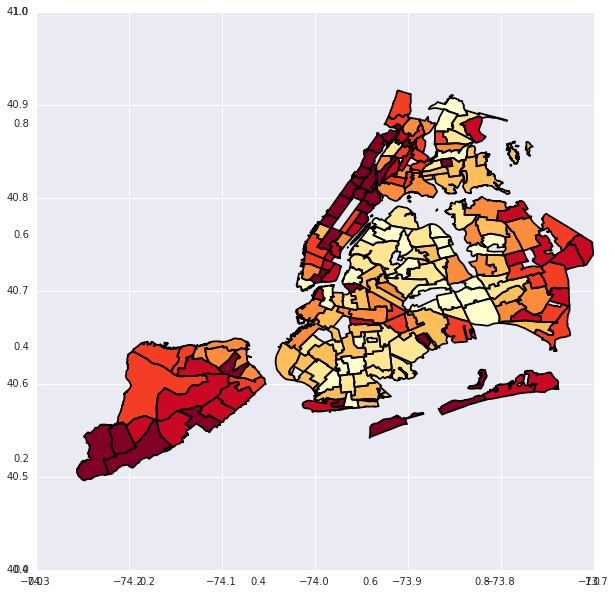

In [31]:
f, ax = plt.subplots(1, figsize=(10,10))
blocked_error_geo.plot(column='blocked error', scheme='QUANTILES', k=7, alpha=1, colormap='YlOrRd')
#mplleaflet.display(fig=f, crs=noise_error_geo.crs,tiles= ('http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png','attributions'))

Highly autocorrelated. There are clusters of high error in Manhattan and Staten Island.

In [32]:
W = ps.buildContiguity(psGeom, criterion='queen', ids=nta_json['ntaname'].values.tolist())
W.transform = 'R'
blocked_error_geo2=pd.merge(nta_json,blocked_error,on=['ntaname'],how='outer').fillna(value=0)
mask=map(lambda x: x in (W.full()[1]),blocked_error_geo2.ntaname)
blocked_error_geo3=blocked_error_geo2[mask]
Y = blocked_error_geo3['blocked error'].values
Y = (Y-Y.mean())/Y.std()
sl = ps.lag_spatial(W, Y)
blocked_error_geo3['w_error'] = sl
mi = ps.Moran(Y, W)
mi.I

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.20675813960939213

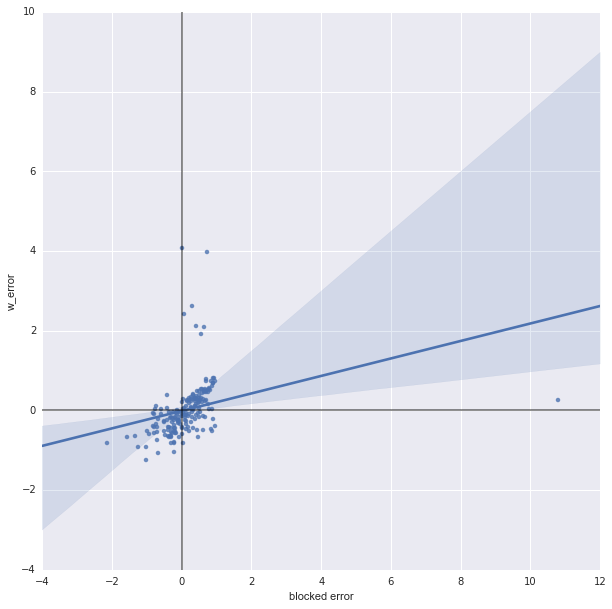

In [33]:
f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(x='blocked error', y='w_error', data=blocked_error_geo3)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

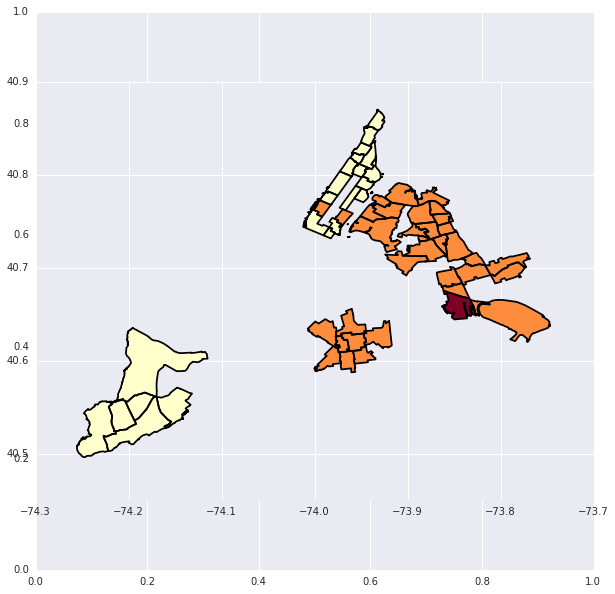

In [34]:
lisa = ps.Moran_Local(Y, W)
S = lisa.p_sim < 0.05
Q = lisa.q
# Next, we'll turn those into a GeoDataFrame for visualization.
records = map(lambda x: (blocked_error_geo3.iloc[x]['ntaname'], Q[x], blocked_error_geo3.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])
gdata = gpd.GeoDataFrame(records, columns=('ntaname', 'quadrant', 'geometry'))
gdata.head()
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='YlOrRd')
#mplleaflet.display(fig=f, crs=noise_error_geo.crs,tiles= ('http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png','attributions'))

In [35]:
quadrantsDf=gdata[['ntaname','quadrant']]
#quadrantsDf.to_csv('Data/quadrantsDf.csv')
merged=pd.merge(blocked_error_geo3,gdata,on=['ntaname'],how='inner')

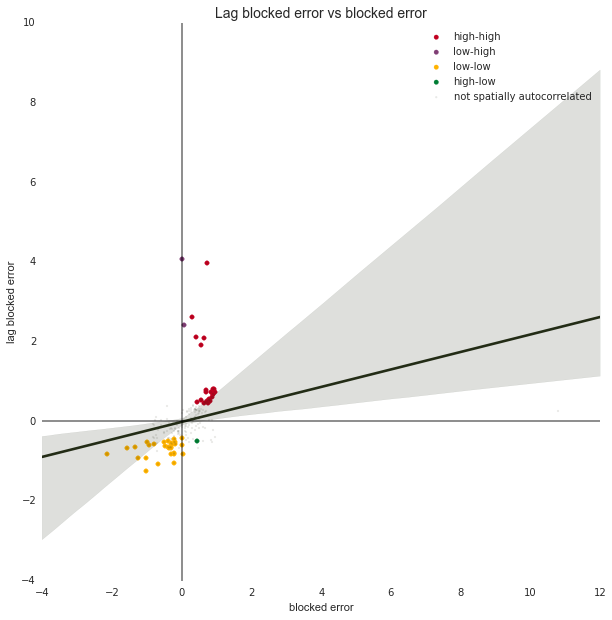

In [36]:
# It's time to look at the Moran Scatter Plot to inspet the results
f, ax = plt.subplots(1, figsize=(10,10))
q1=merged[merged['quadrant']==1]
plt.scatter(x=q1['blocked error'], y=q1['w_error'], color='#C10020',marker='o',label='high-high')
q2=merged[merged['quadrant']==2]
plt.scatter(x=q2['blocked error'], y=q2['w_error'], color='#803E75',marker='o',label='low-high')
q3=merged[merged['quadrant']==3]
plt.scatter(x=q3['blocked error'], y=q3['w_error'], color='#FFB300',marker='o',label='low-low')
q4=merged[merged['quadrant']==4]
plt.scatter(x=q4['blocked error'], y=q4['w_error'], color='#007D34',marker='o',label='high-low')
sns.regplot(x='blocked error', y='w_error', data=blocked_error_geo3, color='#232C16', marker='.',
           scatter_kws={'alpha':0.1}, 
            fit_reg=True, label='not spatially autocorrelated')
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.xlabel('blocked error')
plt.ylabel('lag blocked error')
ax.set_title("Lag blocked error vs blocked error", fontsize=14)
ax.set_axis_bgcolor('w')
#ax.set_axis_bgcolor((1, 0, 0))
pl.plt.legend()

#Step 2a
In the cases with a high Moran's I value, we are going to perform an additional regression with Neighborhood context features. Following the formula

$$\log(S(A,t)) \sim \log (\hat{S} (A,t)) +  \log(\text{ Spatial features})$$

or equivalently,

$$\log(S(A,t) / \hat{S} (A,t)) \sim  \log(\text{ Spatial features})$$

In [37]:
spatial_features=pd.read_csv('datasets/location_features2.csv').drop(['Unnamed: 0'],axis=1).fillna(value=0)
spatial_features.head()

,Neighborhood,Median House Value,Median Age,Median Rent,Median Income,Cars per capita,Building Density,Proportion of Commercial area,Proportion of retail area,Proportion of Office area,Proportion of Residential area,Inbound Commute Density,Population Density,Proportion of Tenants
0,Airport,0,0.00,0,0.0,0.000000,0.063939,1.000000,0.000825,0.000197,0.000000,7687.083553,0.000000,0.000000
1,Allerton-Pelham Gardens,445200,39.70,1538,64702.0,1.129863,0.410404,0.157479,0.040692,0.075124,0.842521,6435.383106,29798.200740,0.404297
2,Annadale-Huguenot-Prince's Bay-Eltingville,527900,41.60,1342,91354.5,1.858472,0.148603,0.125964,0.009717,0.040170,0.874036,1131.370546,5607.873966,0.175620
3,Arden Heights,409750,40.45,1299,88864.5,1.741741,0.287016,0.031889,0.018930,0.008397,0.968111,945.898950,14161.932700,0.111384
4,Astoria,637150,34.10,1432,57798.0,0.422238,0.600337,0.221847,0.066577,0.036913,0.778153,17386.760660,54644.611210,0.829962


In [38]:
spatial_subset=spatial_analysis
phase2_results=pd.DataFrame(index=spatial_subset.index, columns=['R2','best_alpha'])
results={}
for typeof in phase2_results.index:
    results[typeof]={}
    #get the observed and predicted number of calls
    predicted_typeof=pd.DataFrame(predicted_table.loc[typeof]).reset_index().rename(columns={'index':'Neighborhood'})
    observed_typeof=pd.DataFrame(observed_table.loc[typeof]).reset_index().rename(columns={'index':'Neighborhood'})
    #Get X (features) and Y (labels) datasets
    log_predicted=(predicted_typeof[typeof]).replace([np.inf, -np.inf], np.nan).dropna()
    log_observed=(observed_typeof[typeof]).replace([np.inf, -np.inf], np.nan).dropna()
    predicted_typeof['log_obs/log_pred']=np.log(log_observed/log_predicted)
    pred_obs_typeof_log=predicted_typeof[['Neighborhood','log_obs/log_pred']].replace([np.inf, -np.inf], np.nan).dropna()
    complete_table=pd.merge(spatial_features,pred_obs_typeof_log, on=['Neighborhood'],how='inner')
    X_=complete_table[complete_table.columns[1:-1]].fillna(value=0)
    X=X_.copy()
    for feature in X.columns:
        X[feature]=np.log(X[feature])
    X=X.replace([np.inf, -np.inf], np.nan).fillna(value=0)
    Y=complete_table['log_obs/log_pred'].fillna(value=0).replace([np.inf, -np.inf], np.nan)
    #Split in train, validation and test sets
    kf = KFold(n=len(X), n_folds=10, shuffle=True, random_state=21)
    j=0
    for train_index, test_index in kf:
        results[typeof][j]={}
        X_tr, X_test = X.loc[train_index], X.loc[test_index]
        X_train, X_validation = train_test_split(X_tr, test_size=0.2, random_state=21)
        Y_tr, Y_test = Y.loc[train_index], Y.loc[test_index]
        Y_train, Y_validation = train_test_split(Y_tr, test_size=0.2, random_state=21)
        del X_tr
        del Y_tr
        R2_store=[]
        #Find the best parameter for the Lasso 
        for i in np.linspace(0,2,20):
            Lasso = linear_model.Lasso(fit_intercept=True,alpha=i)
            Lasso.fit(X_train,Y_train)
            R2_OS = 1 - np.var(Lasso.predict(X_validation) - Y_validation) / np.var(Y_validation)
            R2_store.append(R2_OS)
        optim_alpha=np.linspace(0,2,20)[np.where(R2_store==np.max(R2_store))[0][0]] 
        results[typeof][j]['best_alpha']=optim_alpha
        Lasso = linear_model.Lasso(fit_intercept=True,alpha=optim_alpha)
        Lasso.fit(X_train,Y_train)
        R2_OS = 1 - np.var(Lasso.predict(X_test) - Y_test) / np.var(Y_test)
        results[typeof][j]['R2']=R2_OS
        j=j+1
    #The optimal alpha is selected for training the Lasso regression with all the features
    #I'm going to take the median of the alphas on the dictionary
    R2_l=[]
    alphas=[]
    for k in results[typeof].keys():
        r2=results[typeof][k]['R2']
        if r2>=0:
            alphas.append(results[typeof][k]['best_alpha'])
        R2_l.append(r2)
    final_r2=np.mean(R2_l)
    final_alpha=np.median(alphas)
    phase2_results.loc[typeof,'R2']=final_r2
    phase2_results.loc[typeof,'best_alpha']=final_alpha
            

C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:36: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\Marco\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\Marco\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:42: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [39]:
phase2_results

,R2,best_alpha
Lead,0.144454,0
WATER LEAK,-0.08336146,0.1052632
Bus Stop Shelter Placement,0.007825224,0.1052632
Found Property,0.02611538,0.3157895
For Hire Vehicle Complaint,-0.06529506,0
New Tree Request,0.2818923,0
Consumer Complaint,0.0903707,0
Other Enforcement,0.1666568,0
General Construction/Plumbing,0.1167197,0
Boilers,-0.2327922,0.1052632


To do: run the regressions for the types of complains with R squares greater than 0.2, and with the whole set as training. Get results, analyze.

In [40]:
phase2_filtered=phase2_results[phase2_results['R2']>=0.1]
len(phase2_filtered)

22

In [41]:
phase2_coefficients=pd.DataFrame(index=phase2_filtered.index,columns=list(X.columns)+['R2 os']) #table to store the coefficients of Lasso
phase2_log_predictions=pd.DataFrame(index=phase2_filtered.index, columns=spatial_features['Neighborhood']) #table with the prediction of calls
for typeof in phase2_filtered.index:
    predicted_typeof=pd.DataFrame(predicted_table.loc[typeof]).reset_index().rename(columns={'index':'Neighborhood'})
    observed_typeof=pd.DataFrame(observed_table.loc[typeof]).reset_index().rename(columns={'index':'Neighborhood'})
    #Get X (features) and Y (labels) datasets
    log_predicted=(predicted_typeof[typeof]).replace([np.inf, -np.inf], np.nan).dropna()
    log_observed=(observed_typeof[typeof]).replace([np.inf, -np.inf], np.nan).dropna()
    predicted_typeof['log_obs/log_pred']=np.log(log_observed/log_predicted)
    pred_obs_typeof_log=predicted_typeof[['Neighborhood','log_obs/log_pred']].replace([np.inf, -np.inf], np.nan).dropna()
    complete_table=pd.merge(spatial_features,pred_obs_typeof_log, on=['Neighborhood'],how='inner')
    X_=complete_table[complete_table.columns[1:-1]].fillna(value=0)
    X=X_.copy()
    for feature in X.columns:
        X[feature]=np.log(X[feature])
    X=X.replace([np.inf, -np.inf], np.nan).fillna(value=0)
    Y=complete_table['log_obs/log_pred'].fillna(value=0).replace([np.inf, -np.inf], np.nan)    
    Lasso = linear_model.Lasso(fit_intercept=True,alpha=phase2_results.loc[typeof,'best_alpha'])
    Lasso.fit(X,Y)
    myfeat=X.columns[abs(Lasso.coef_)>0]
    X=complete_table[myfeat].fillna(value=0)
    if len(X.columns)!=0:
        ordinary_LS=sm.OLS(Y, statsmodels.tools.add_constant(X)).fit()
        rsq=ordinary_LS.rsquared
        table=ordinary_LS.conf_int()
        table['std_dv']=(table[1]-table[0])/4
        table['coef']=ordinary_LS.params
        table.drop([0,1],inplace=True,axis=1) 
        phase2_coefficients.loc[typeof,'R2 os']="%.3f"%phase2_filtered.loc[typeof,'R2']
        product=1
        for variable in table.index:
            coeff_value=table.loc[variable,'coef']
            coeff_std=table.loc[variable,'std_dv']
            val_coef="%.8f +/- %.8f" % (coeff_value, coeff_std)
            phase2_coefficients.loc[typeof,variable]=val_coef
            if variable!='const':
                product=product*(X[variable]**coeff_value)
        new_table=pd.DataFrame(index=complete_table['Neighborhood'],columns=['Prediction'])
        new_table['Prediction']=(np.array(product*np.exp(ordinary_LS.params['const'])))
        for neighb in new_table.index:
            phase2_log_predictions.loc[typeof,neighb]=new_table.loc[neighb,'Prediction']*predicted_table.loc[typeof,neighb]
    


C:\Users\Marco\Anaconda\lib\site-packages\IPython\kernel\__main__.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [42]:
phase2_coefficients.fillna(value=0,inplace=True)
phase2_coefficients

,Median House Value,Median Age,Median Rent,Median Income,Cars per capita,Building Density,Proportion of Commercial area,Proportion of retail area,Proportion of Office area,Proportion of Residential area,Inbound Commute Density,Population Density,Proportion of Tenants,R2 os,const
Lead,0.00000085 +/- 0.00000036,-0.01269008 +/- 0.01117613,-0.00007434 +/- 0.00029186,0.00000508 +/- 0.00000417,-0.12307112 +/- 0.40383403,1.78356541 +/- 0.63056056,0.88270118 +/- 1.11380636,-3.25486393 +/- 1.77661590,-2.93935487 +/- 0.91939825,0.55045215 +/- 1.04543988,0.00000046 +/- 0.00000064,-0.00001408 +/- 0.00000295,0.57835937 +/- 0.73156921,0.144,-1.21190263 +/- 1.57669901
New Tree Request,0.00000349 +/- 0.00000046,-0.00611463 +/- 0.01372496,0.00039096 +/- 0.00035868,-0.00002024 +/- 0.00000518,-0.51099539 +/- 0.45663826,0.92065698 +/- 0.76516113,3.18311300 +/- 1.44470477,0.64628689 +/- 2.25249994,-1.41705184 +/- 1.16859776,3.30133009 +/- 1.36725391,0.00000051 +/- 0.00000082,-0.00001227 +/- 0.00000375,-2.56266413 +/- 0.86472980,0.282,-2.44435353 +/- 2.02176917
Other Enforcement,0.00000180 +/- 0.00000033,-0.04188207 +/- 0.00976464,-0.00028989 +/- 0.00025230,0.00000063 +/- 0.00000365,-0.60333108 +/- 0.32025544,0.11701759 +/- 0.53671363,-3.21900735 +/- 1.01309208,6.56081249 +/- 1.58553832,0.02822423 +/- 0.82034745,-2.42847226 +/- 0.95919736,-0.00000003 +/- 0.00000058,-0.00000775 +/- 0.00000266,-1.59034432 +/- 0.61187466,0.167,4.77059231 +/- 1.42094201
General Construction/Plumbing,0.00000165 +/- 0.00000034,-0.01381263 +/- 0.00985262,-0.00009490 +/- 0.00026270,-0.00000427 +/- 0.00000378,0.27264894 +/- 0.32326683,1.31818310 +/- 0.52644859,-0.55712011 +/- 1.04975341,3.93814542 +/- 1.64862714,-0.24469809 +/- 0.81227618,-0.36802713 +/- 0.99815198,-0.00000020 +/- 0.00000060,-0.00000468 +/- 0.00000274,-0.16472143 +/- 0.62891285,0.117,-0.50194467 +/- 1.43976131
Graffiti,0.00000148 +/- 0.00000050,-0.04481406 +/- 0.01457279,0.00075321 +/- 0.00038855,-0.00001877 +/- 0.00000560,-0.28980640 +/- 0.47813696,1.60271116 +/- 0.77865870,0.95386967 +/- 1.55266751,9.79905670 +/- 2.43844866,-1.81007598 +/- 1.20142008,0.62112184 +/- 1.47634494,-0.00000059 +/- 0.00000088,-0.00001065 +/- 0.00000405,-1.06986367 +/- 0.93021136,0.137,0.11862616 +/- 2.12951973
Taxi Complaint,0.00000013 +/- 0.00000049,0.00032477 +/- 0.01437584,0.00022001 +/- 0.00039466,0.00001846 +/- 0.00000552,-0.49056996 +/- 0.47366244,0.58719430 +/- 0.77294559,0.48560853 +/- 1.50951552,3.80563578 +/- 2.45433704,-3.32739869 +/- 1.16965226,-1.33751350 +/- 1.42843948,-0.00000090 +/- 0.00000085,0.00000435 +/- 0.00000395,0.48374365 +/- 0.91162042,0.234,-1.73766876 +/- 2.07543922
HEAT/HOT WATER,0,0,0,0,0,0,0,0,0,0,0,0.00001423 +/- 0.00000174,0,0.152,-1.07465192 +/- 0.09099632
Noise,0.00000103 +/- 0.00000024,0,0,0.00000068 +/- 0.00000168,0,0,0,0,0,0,0.00000067 +/- 0.00000032,0,0,0.149,-0.90416731 +/- 0.11187706
Construction,0,0,0,0,1.57642797 +/- 0.30272422,0,0,0,-3.22517977 +/- 3.34785474,0,-0.00000220 +/- 0.00000312,0,0,0.189,-1.88408293 +/- 0.29882928
HEATING,0,0,0,0,0,0,0,0,0,0,0,0.00001194 +/- 0.00000170,0,0.147,-0.95019670 +/- 0.08929539


In [43]:
phase2_log_predictions


Neighborhood,Airport,Allerton-Pelham Gardens,Annadale-Huguenot-Prince's Bay-Eltingville,Arden Heights,Astoria,Auburndale,Baisley Park,Bath Beach,Battery Park City-Lower Manhattan,Bay Ridge,...,Windsor Terrace,Woodhaven,Woodlawn-Wakefield,Woodside,Yorkville,park-cemetery-etc-Bronx,park-cemetery-etc-Brooklyn,park-cemetery-etc-Manhattan,park-cemetery-etc-Queens,park-cemetery-etc-Staten Island
Lead,NaN,2230969,1.475063e+08,9.570614e+08,7.274886e+07,1.478522e+07,4.444791e+09,4.689069e+07,427494.3,3.181119e+07,...,7.689499e+10,2.953417e+08,4.479573e+08,8.27013e+07,9.527262e+09,NaN,NaN,NaN,NaN,NaN
New Tree Request,NaN,0.238061,0.3127437,0.4361137,1.997083,0.6195357,4.036524,0.3144109,0.01932094,0.4793175,...,2.584025,1.972484,0.7476485,1.984313,2.001639,NaN,NaN,NaN,0.001189165,NaN
Other Enforcement,NaN,0.003056954,1.189086e-06,0.01264584,0.04356605,0.001857896,0.0004291477,0.005973779,0.0002723666,0.01044018,...,6.897265e-05,0.01675573,0.001141956,0.003096827,0.003873353,NaN,NaN,0,7.077422e-07,NaN
General Construction/Plumbing,NaN,0.0003988028,6.403919e-07,6.437306e-05,0.007512523,0.0002489174,0.0001229937,0.0009151641,0.0002585353,0.001461364,...,0.0001135671,0.001875053,0.0003309221,0.00147011,0.001302717,1.048423e-10,NaN,NaN,5.624773e-08,NaN
Graffiti,NaN,9.620847e-12,5.707701e-18,8.49374e-14,2.865528e-08,8.30921e-12,1.245924e-11,1.334831e-10,4.062523e-13,2.313763e-10,...,4.751976e-12,1.491955e-09,2.176985e-11,1.118249e-09,1.004948e-10,4.222291e-25,NaN,NaN,7.150996e-18,NaN
Taxi Complaint,NaN,0.03293992,0.0001062676,NaN,17.20329,0.1093381,11.49868,0.9230756,0.01148058,0.5130365,...,34.46978,11.49577,1.701951,4.728455,20.96897,8.317884e-08,NaN,NaN,2.433248,NaN
HEAT/HOT WATER,NaN,105.9826,35.0113,24.65524,573.2945,39.59736,126.4756,144.6913,133.376,458.0701,...,99.92454,258.8499,212.2581,246.398,398.9186,14.99793,NaN,84.61565,3.315452,NaN
Noise,NaN,42.53691,48.85536,34.91902,248.6207,47.3504,24.29702,56.7305,407.7689,192.7318,...,86.89429,47.0912,51.7037,94.92841,584.0839,13.75915,NaN,27.47261,13.14359,NaN
Construction,NaN,16497.56,NaN,NaN,102171.2,562817.9,8.602459e+07,198000.4,NaN,30237.74,...,NaN,7575901,875523.6,281277.4,NaN,NaN,NaN,inf,3615186,NaN
HEATING,NaN,82.81482,12.05489,4.896898,487.8464,25.4186,105.0942,119.1742,73.54128,373.4488,...,78.66086,216.7663,178.6155,208.1083,283.9415,15.89874,NaN,77.06412,NaN,NaN


In [44]:
phase2_coefficients.to_csv('outputs/phase2_coefficients.csv')
phase2_log_predictions.to_csv('outputs/phase2_predicted.csv')
phase2_filtered.to_csv('outputs/phase2_regressions.csv')